# Extract background features

Image -> Grayscale -> cropped into patches -> Find features to characterize the background features. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
import pandas
from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *


Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [3]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 224
patch_half_size = patch_size / 2
stride = 56
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# Inside
# crop_x_min = 4000
# crop_x_max = 6000
# crop_y_min = 2400
# crop_y_max = 4400

# Whole
crop_x_min = 0
crop_y_min = 0
_, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)

crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

def get_filename(define_list):
    """
    get_finelname(list_of_definition_component): return a string concaining filename definition, seperated by '_' 
    """
    filename_head = ''
    for filename_element in map(str,define_list):
        filename_head = filename_head + filename_element + '_'
    return filename_head

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;


save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Extract_background_features/'
if os.path.isdir(save_folder_path):
    sys.stderr.write('Folder already exists.')
else:
    os.makedirs(save_folder_path)
    sys.stderr.write('Folder created.')

Folder already exists.

In [4]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 201)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files are already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           


Image files are already available. 


In [5]:
im_cropped = []
for imIndex in img_filename:
# for imIndex in [img_filename[0]]:
     im_cropped.append(img_as_ubyte(rgb2gray(imread(imIndex)[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    
im_cropped_h, im_cropped_w = im_cropped[0].shape[:2]

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [6]:
# display_image(imread(img_filename[0]))

In [7]:
def rescale_grayscale_image(input,invcol=False):
    input = np.array(input);
    vmin = np.percentile(input, 0);
    vmax = np.percentile(input, 100);
    rescale_image = (input - vmin ) / (vmax - vmin);
    rescale_image = np.maximum(np.minimum(rescale_image, 1), 0)
    rescale_image = img_as_ubyte(rescale_image)
    if invcol:
        rescale_image = 255 - rescale_image
    return rescale_image
    

In [8]:
option_rescale_grayscale = True
option_inverse_color = False
secIndex = 0

if option_rescale_grayscale:
    tempImage = rescale_grayscale_image(im_cropped[secIndex],invcol=option_inverse_color)
#     tempImage = im_cropped[secIndex]
#     vmin = np.percentile(tempImage, 0)
#     vmax = np.percentile(tempImage, 100)
#     tempImage = (tempImage - vmin) / (vmax - vmin)
#     tempImage = np.maximum(np.minimum(tempImage, 1), 0)
#     tempImage = img_as_ubyte(tempImage)
#     if option_inverse_color:
#         tempImage = 255 - img_as_ubyte(tempImage)
else:
    tempImage = im_cropped[secIndex]

In [9]:
'Normalized rescaled grayscale histrogram of cropped original image\n Image size: {} * {}'.format(crop_image_height, crop_image_width)

'Normalized rescaled grayscale histrogram of cropped original image\n Image size: 11936 * 15520'

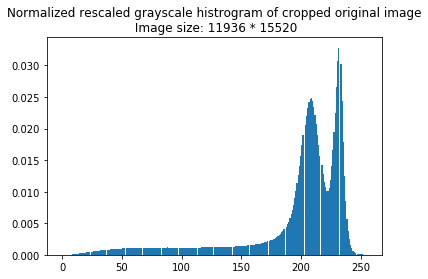

In [10]:
plt.hist(tempImage.flatten(), bins=256, normed=True);
plt.title('Normalized rescaled grayscale histrogram of cropped original image\n Image size: {} * {}'.format(crop_image_height, crop_image_width))
plt.show()

In [11]:
grayscale_AccPtl = [(percentile, np.percentile(tempImage.flatten(), percentile)) for percentile in range(0,100,5)]
grayscale_AccPtl

[(0, 0.0),
 (5, 76.0),
 (10, 123.0),
 (15, 163.0),
 (20, 185.0),
 (25, 195.0),
 (30, 199.0),
 (35, 202.0),
 (40, 206.0),
 (45, 208.0),
 (50, 210.0),
 (55, 212.0),
 (60, 214.0),
 (65, 218.0),
 (70, 223.0),
 (75, 227.0),
 (80, 229.0),
 (85, 231.0),
 (90, 234.0),
 (95, 236.0)]

# Global Threshold - Otsu

In [12]:
from skimage.filters import threshold_otsu
otsu_thresh = threshold_otsu(tempImage)
tempImage_BW = tempImage <= otsu_thresh

In [13]:
# Detected area
detected_total_area = np.sum(tempImage_BW)
detected_total_area_ratio = detected_total_area / float(crop_image_height * crop_image_width)
print('Total detected area ratio is %f' %detected_total_area_ratio)

Total detected area ratio is 0.133659


In [51]:
# Get image matrix of each patch 
patches = [tempImage[y - patch_half_size : y + patch_half_size, x - patch_half_size : x + patch_half_size].copy() for x, y in patch_center_pixel_location]
patch_area = patch_size ** 2
patches_BW = [tempPatches <= otsu_thresh for tempPatches in patches]
patch_detected_area_ratio = np.array([np.sum(patches_BW[tempI])/float(patch_area) for tempI in range(len(patches))])

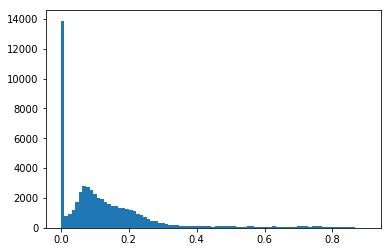

In [15]:
plt.hist(patch_detected_area_ratio,85);

In [26]:
patch_density_classes = {}
for tempTH in np.arange(0,100,10):
    temp_ratio = (patch_detected_area_ratio > tempTH/float(100)) * (patch_detected_area_ratio <= tempTH/float(100) + 0.1 )
    temp_ratio = np.where(temp_ratio == True)[0]
    patch_density_classes[tempTH] = temp_ratio.tolist()
    
# patch_rL08_index = patch_detected_area_ratio > 0.8
# patch_rL08_index = np.where(patch_rL08_index == True)[0]
# patch_rL08_index = patch_rL08_index.tolist()
# patch_density_classes[80] = patch_rL08_index

In [268]:
viz_index[0]

2040

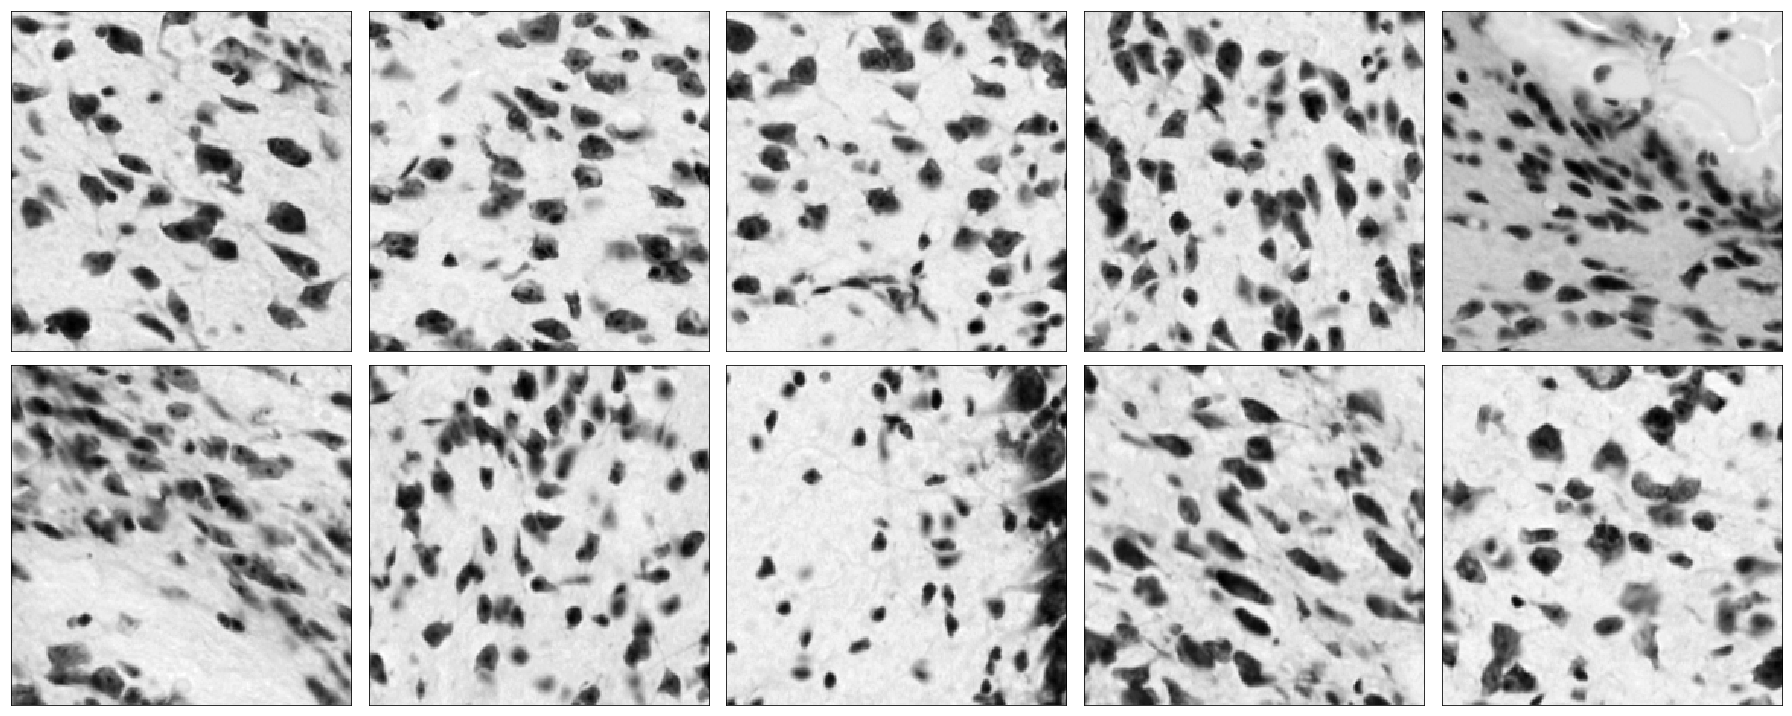

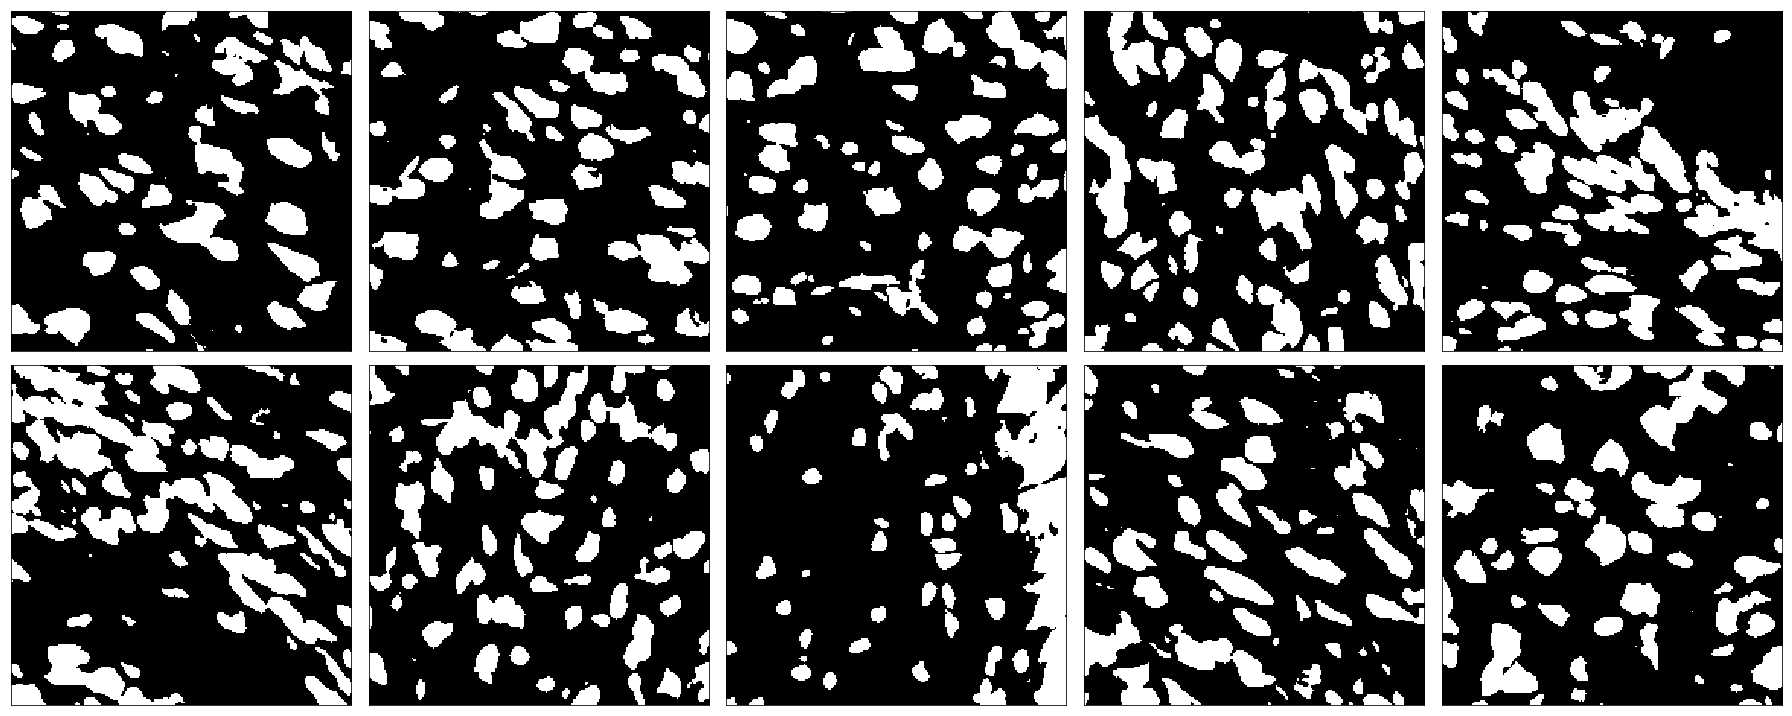

In [267]:
viz_index = np.random.choice(patch_density_classes[20],10).tolist()
viz_patches_list = [patches[index1] for index1 in viz_index]
display_images_in_grids(viz_patches_list, nc=5, cmap=plt.cm.gray)
display_images_in_grids([patches_BW[index1] for index1 in viz_index], nc=5, cmap=plt.cm.gray)

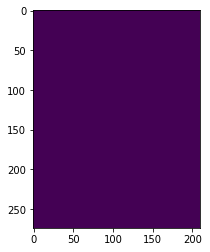

In [436]:
patch_center_pixel_index = patch_center_pixel_location/56 - 2
patch_loc_plot = np.zeros(np.max(patch_center_pixel_index,axis=0)+1)
plt.imshow(patch_loc_plot)

In [447]:
def viz_classes(data_dic,patch_loc_list,nornmalized=True,transposed=True,patch_stride=56):
    """
    vis_classes(data_dic,patch_loc_index,nornmalized=True,transposed=True,patch_stride=56)
    data_dic = {key_value : indexes}
    patch_loc_index:
    """
    # Get an array of the index location of each patches
    patch_center_pixel_index = patch_loc_list/patch_stride - 2
    patch_loc_plot = np.zeros(np.max(patch_center_pixel_index,axis=0)+1)
    for tempKey in data_dic.viewkeys():
        for temoLoc in patch_center_pixel_index[data_dic[tempKey]]:
            try:
                patch_loc_plot[temoLoc[0], temoLoc[1]]=tempKey
            except:
                sys.stderr.write('Index location out of range'+str(temoLoc));
    if nornmalized:
        try:
            patch_loc_plot = rescale_grayscale_image(patch_loc_plot)
        except:
            sys.stderr('Cannot rescale the grayscale image. Check if function rescale_grayscale_image is available.')
    if transposed:
        patch_loc_plot = np.transpose(patch_loc_plot)
    return patch_loc_plot
        

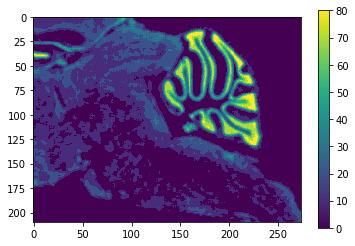

In [451]:
plt.imshow(viz_classes(patch_density_classes,patch_center_pixel_location,nornmalized=False))
plt.colorbar()

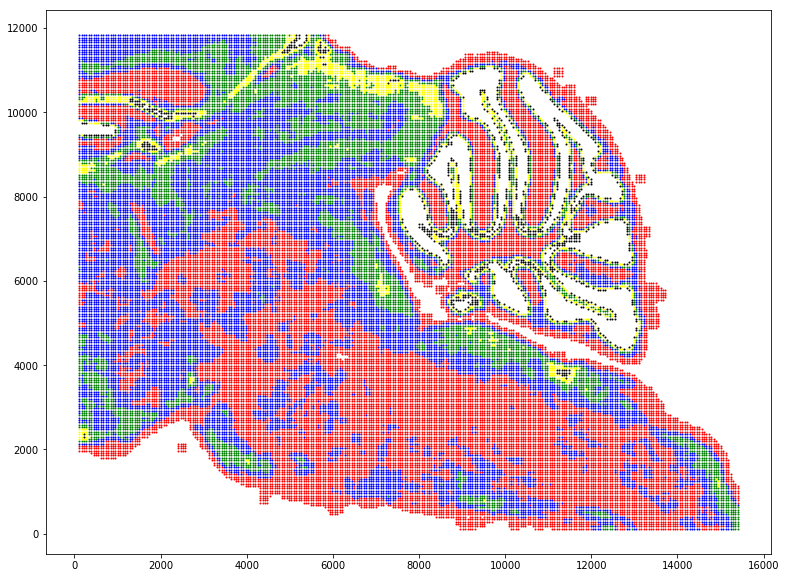

In [28]:
aspectiao = crop_image_width/float(crop_image_height)
plt.figure(figsize=(10*aspectiao, 10))
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[0]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='red', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[10]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='blue', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[20]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='green', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[30]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='yellow', s=1);
plt.hold
viz_patches_centLoc_list = patch_center_pixel_location[patch_density_classes[40]]
plt.scatter(viz_patches_centLoc_list[:,0],crop_image_height - viz_patches_centLoc_list[:,1],color='black', s=1);

# Background Features

In [299]:
from scipy import ndimage as ndi
from scipy.signal import argrelmax
from scipy.stats import linregress

In [143]:
def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = ndi.morphology.generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
#     local_max = ndi.maximum_filter(image, footprint=neighborhood)==image
    local_max = ndi.maximum_filter(image, size=5)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = ndi.morphology.binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background
    print('I did not got stuck!')
    return detected_peaks

In [335]:
tempPatchIndex = np.random.choice(patch_density_classes[0],1)[0];

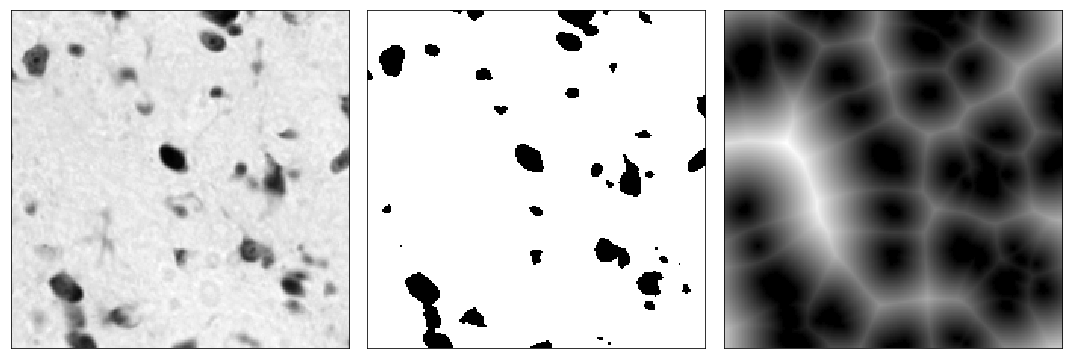

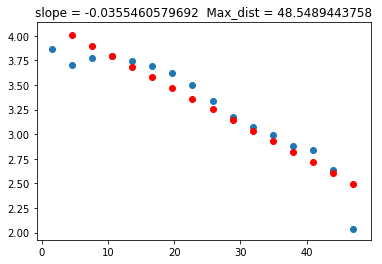

In [336]:
tempPatch = patches[tempPatchIndex];
tempPatch_BW = tempPatch >= otsu_thresh

# Distance Map
distance_im = ndi.morphology.distance_transform_edt(tempPatch_BW)
distance_im_n = rescale_grayscale_image(distance_im)
n_dis_hist_bins = 16;
dis_hist_max = np.max(distance_im.flatten())
dis_hist_min = np.min(distance_im.flatten())
dis_hist_bins = np.linspace(dis_hist_min, dis_hist_max, num=n_dis_hist_bins+1)
distance_im_his = np.histogram(distance_im.flatten(),bins=dis_hist_bins)
dis_hist_bins_mid = np.convolve(distance_im_his[1],np.ones((2,))/2,mode='valid')

dis_hist_count_log = np.log10(distance_im_his[0][1:])
dis_hist_LF = linregress(dis_hist_bins_mid[1:], dis_hist_count_log)

display_images_in_grids([tempPatch, tempPatch_BW,distance_im_n], nc=3, cmap=plt.cm.gray)
plt.scatter(dis_hist_bins_mid,np.log10(distance_im_his[0]));
plt.hold
plt.scatter(dis_hist_bins_mid[1:],dis_hist_LF.slope * dis_hist_bins_mid[1:] + dis_hist_LF.intercept,color='red');
plt.title('slope = '+str(dis_hist_LF.slope)+'  Max_dist = '+str(dis_hist_max))

3796  slope = -0.0444091328995  Max_dist = 41.2310562562


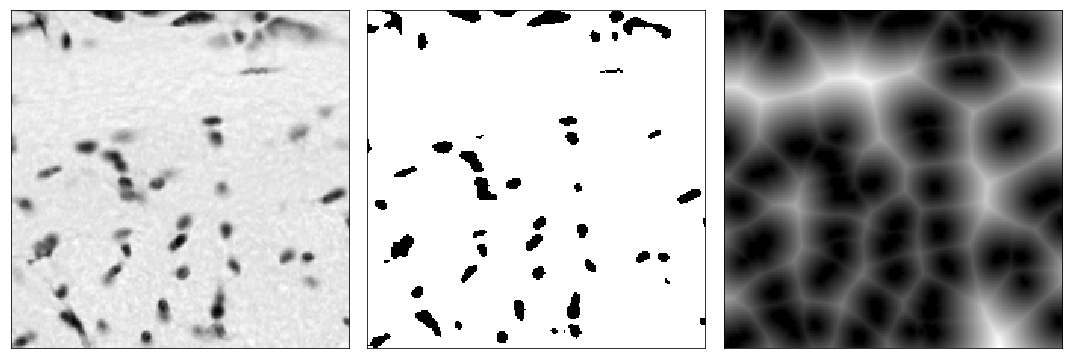

4010  slope = -0.0538218464137  Max_dist = 46.0108682813


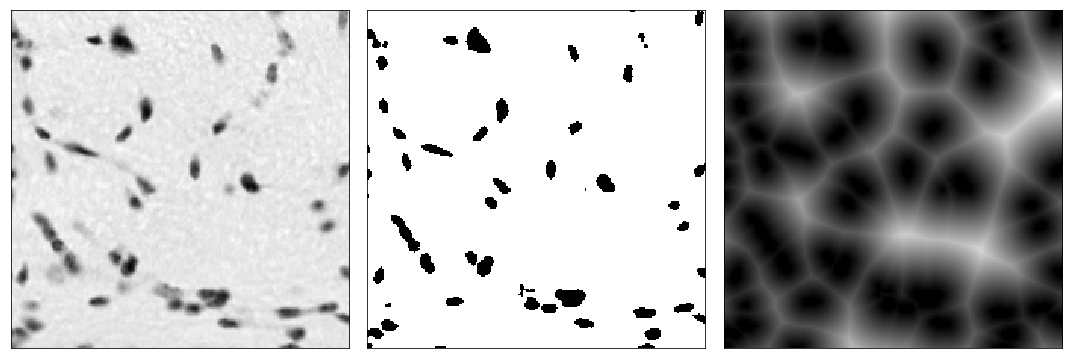

28127  slope = -0.0210331469104  Max_dist = 73.0068489938


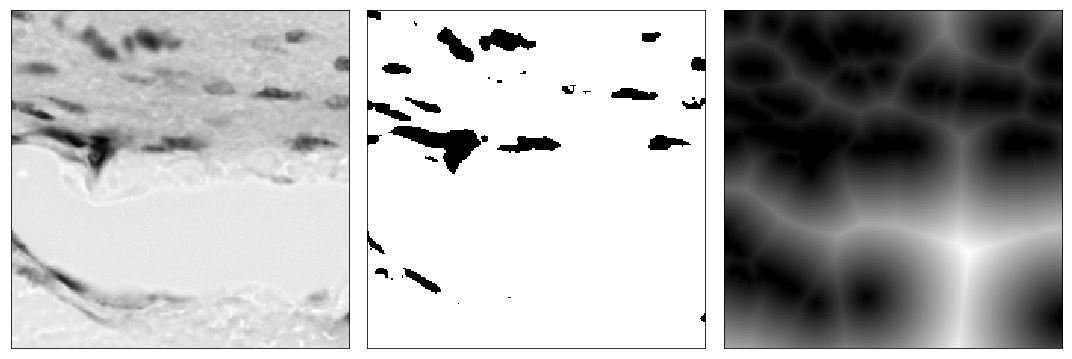

8288  slope = -0.0439539895381  Max_dist = 66.6108099335


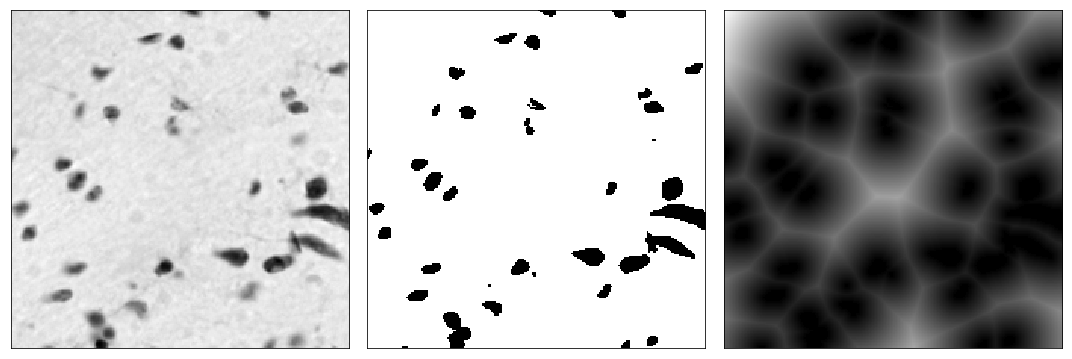

3668  slope = -0.0341603067352  Max_dist = 54.4518135602


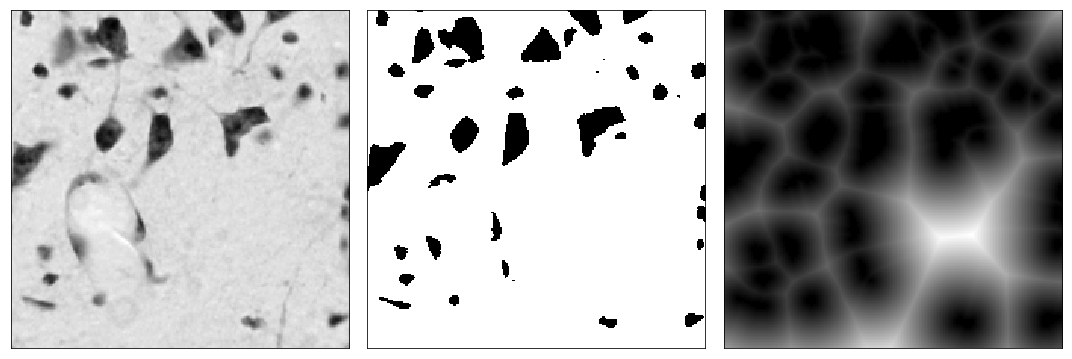

31235  slope = -0.0312239253676  Max_dist = 73.9256383131


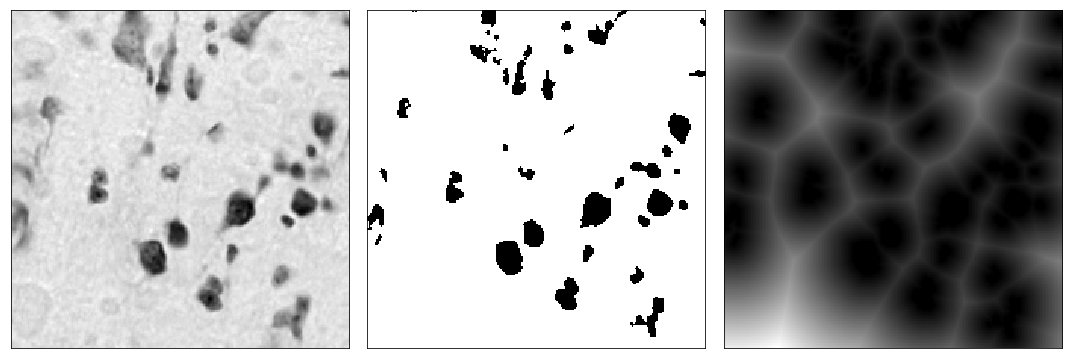

18173  slope = -0.0364009133966  Max_dist = 48.7647413609


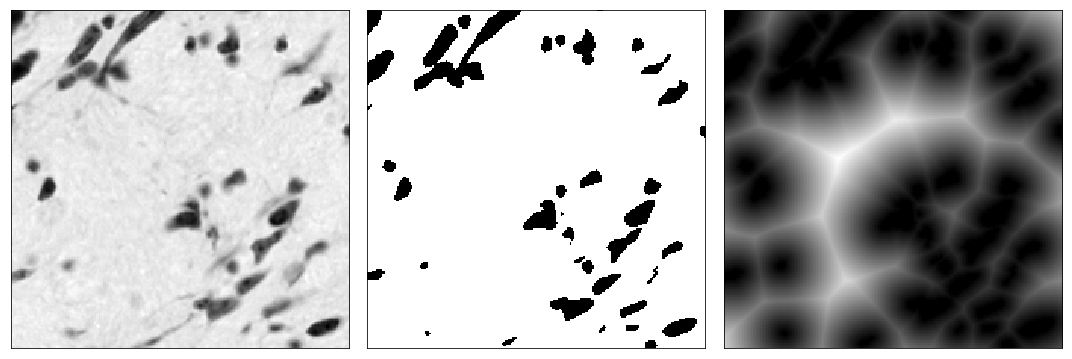

43080  slope = -0.0280652682424  Max_dist = 87.0


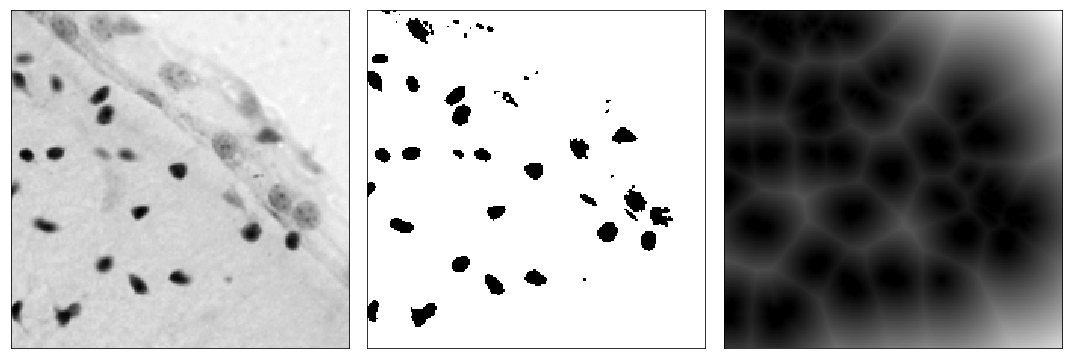

42653  slope = -0.0052037361337  Max_dist = 150.073315416


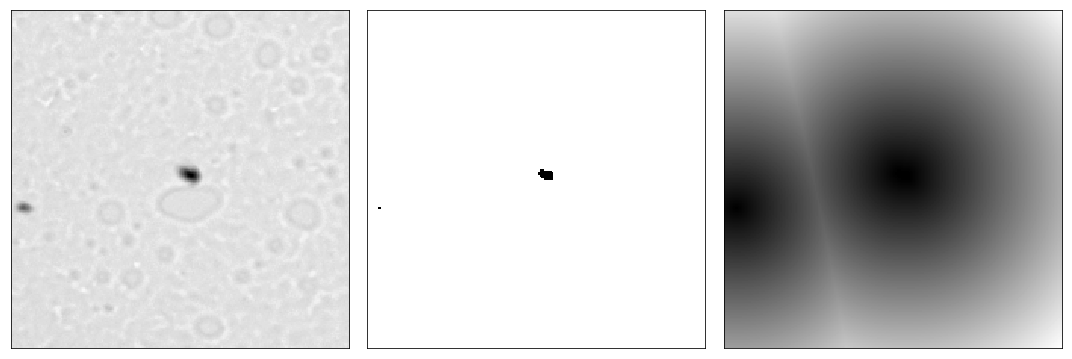

40803  slope = -0.0326676191316  Max_dist = 70.4911341943


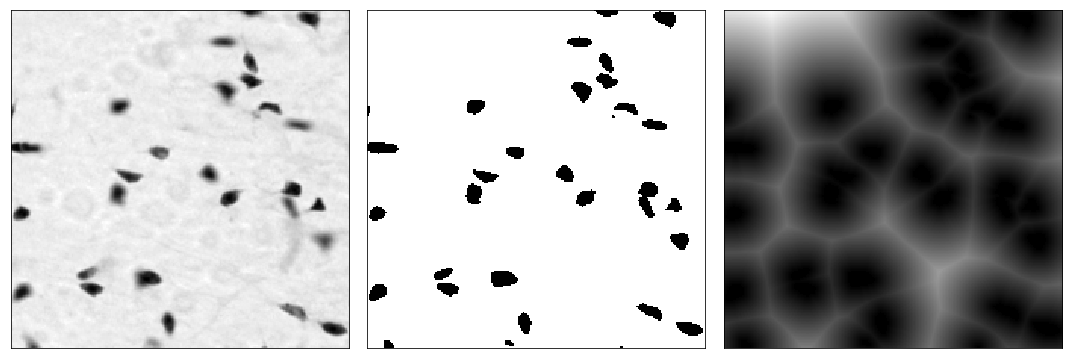

In [345]:
# Combine
tempPatchIndex_List = np.random.choice(patch_density_classes[0],10)
for tempPatchIndex in tempPatchIndex_List:
    tempPatch = patches[tempPatchIndex];
    tempPatch_BW = tempPatch >= otsu_thresh

    # Distance Map
    distance_im = ndi.morphology.distance_transform_edt(tempPatch_BW)
    distance_im_n = rescale_grayscale_image(distance_im)
    n_dis_hist_bins = 16;
    dis_hist_max = np.max(distance_im.flatten())
    dis_hist_min = np.min(distance_im.flatten())
    dis_hist_bins = np.linspace(dis_hist_min, dis_hist_max, num=n_dis_hist_bins+1)
    distance_im_his = np.histogram(distance_im.flatten(),bins=dis_hist_bins)
    dis_hist_bins_mid = np.convolve(distance_im_his[1],np.ones((2,))/2,mode='valid')

    dis_hist_count_log = np.log10(distance_im_his[0][1:])
    dis_hist_LF = linregress(dis_hist_bins_mid[1:], dis_hist_count_log)
    plt.figure();
#     plt.imshow(tempPatch,cmap=plt.cm.gray)
    print(str(tempPatchIndex)+'  slope = '+str(dis_hist_LF.slope)+'  Max_dist = '+str(dis_hist_max));
    display_images_in_grids([tempPatch, tempPatch_BW,distance_im_n], nc=3, cmap=plt.cm.gray);

    # plt.scatter(dis_hist_bins_mid,np.log10(distance_im_his[0]));
    # plt.hold
    # plt.scatter(dis_hist_bins_mid[1:],dis_hist_LF.slope * dis_hist_bins_mid[1:] + dis_hist_LF.intercept,color='red');


## Distance Map

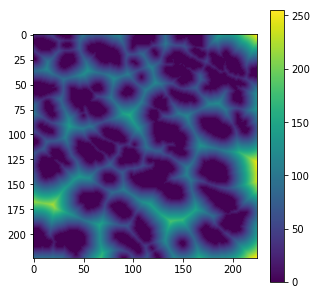

In [272]:
# distance_im = ndi.morphology.distance_transform_edt(tempPatch_BW)
# distance_im_n = rescale_grayscale_image(distance_im)
# plt.figure(figsize=(5,5))
# plt.imshow(distance_im_n);
# plt.colorbar();
# distance_im

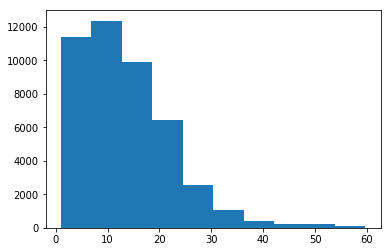

In [259]:
distIm_Largest10 = np.sort(distance_im.flatten())[-10:]
plt.hist(distance_im[(np.nonzero(distance_im))]);

In [202]:
np.sort(distIm_Largest10)

array([223, 223, 223, 223, 225, 225, 230, 232, 243, 255], dtype=uint8)

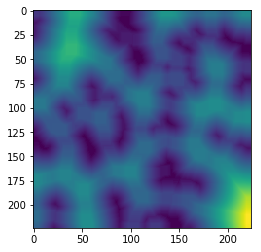

In [213]:
plt.imshow( ndi.maximum_filter(distance_im, size=10))

I did not got stuck!


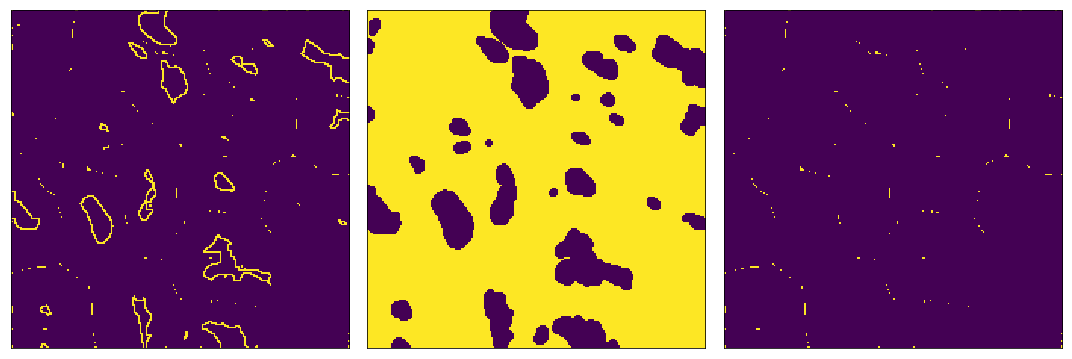

In [210]:
# Find the local maximum 
patch_local_dis_10 = distance_im > 10
patch_local_dis_max = detect_peaks(distance_im)
# plt.scatter(patch_local_dis_max[1],patch_local_dis_max[0])
display_images_in_grids([patch_local_dis_max,patch_local_dis_10,patch_local_dis_max*patch_local_dis_10],nc=3)

# To-do List
1. Write a function to visualize the score map for each features
2. Find feature to characterize hole/ fiber
    (a) downscale the image after Gaussian filter
    
3. Is the decay of the distance map histrogram stable? Calculate the ratio between consecutive bins to get the decay constant? 
    (a) The histogram of distance map looks like a correlation function
    
